In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import t, ttest_ind


In [3]:
# Load the Excel file
file_path = './Grupo_3.xlsx'

# Load the sheet names
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)  # This will show the available sheet names

# Load each sheet into a separate DataFrame
dfSantaAna = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
dfLaFloresta = pd.read_excel(xls, sheet_name=xls.sheet_names[1])

# Optional: Show the first few rows of each DataFrame
print(dfSantaAna.head())
print(dfLaFloresta.head())

['Santa Ana', 'La Floresta']
       Fecha        Ventas
0 2023-01-01  12622.120347
1 2023-01-02  19769.873469
2 2023-01-03  20177.671875
3 2023-01-04  17454.600891
4 2023-01-05  17672.242987
       Fecha        Ventas
0 2023-01-01  14767.536664
1 2023-01-02  13889.323232
2 2023-01-03  11491.085327
3 2023-01-04  18903.512075
4 2023-01-05  13703.219431


In [4]:
#Agrego una columna para identificar la tienda
dfLaFloresta['Tienda'] = 'La Floresta'
dfSantaAna['Tienda'] = 'Santa Ana'

In [5]:
#Función para agrupar las ventas por mes
def ventas_por_mes(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
    df['mes'] = df['Fecha'].dt.month
    df['Nombre_Mes'] = df['Fecha'].dt.month_name()
    return df

In [6]:
dfLaFloresta_mensual = ventas_por_mes(dfLaFloresta)
dfSantaAna_mensual = ventas_por_mes(dfSantaAna) 

In [7]:
# Aseguramos que los nombres de las columnas sean consistentes
dfSantaAna = dfSantaAna.rename(columns={'Ventas': 'Ventas', 'mes': 'mes', 'Nombre_Mes': 'Nombre_Mes'})
dfLaFloresta = dfLaFloresta.rename(columns={'Ventas': 'Ventas', 'mes': 'mes', 'Nombre_Mes': 'Nombre_Mes'})

In [8]:
# combinamos los DataFrames para tener un solo DataFrame
df = pd.concat([dfSantaAna, dfLaFloresta], ignore_index=True)

In [9]:
# Hacemos un merge de los DataFrames para tener un solo DataFrame con las ventas de ambas tiendas
# Esto lo precisamos para ver el total de ventas por mes, y decidir el mejor mes combinado para tomar las vacaciones.
dfCombinado = pd.merge(
    dfSantaAna[['Fecha', 'Ventas', 'mes', 'Nombre_Mes']],
    dfLaFloresta[['Fecha', 'Ventas']],
    on='Fecha',
    suffixes=('_SantaAna', '_LaFloresta')
)
dfCombinado['Ventas'] = dfCombinado['Ventas_SantaAna'] + dfCombinado['Ventas_LaFloresta']
dfCombinado['Tienda'] = 'Ambas Tiendas Combinadas'
dfCombinado = dfCombinado[['Fecha', 'Ventas', 'mes', 'Nombre_Mes', 'Tienda']]


### Funciones principales para la impresión de los gráficos 

In [10]:
#Funcion para graficar las ventas por mes de acuerdo a la funcion requerida
# La funcion recibe uno o dos DataFrames, el tipo de gráfico, y procede a graficar las ventas por mes.
def plot_por_mes(df1 , df2=None, plot_type='kde', filename_prefix=''):
    # Ver que tengan las columnas requeridas
    required_columns = ['mes', 'Ventas', 'Tienda']
    if not all(col in df1.columns for col in required_columns):
        raise ValueError("Los Dataframes deben de tener las columnas de  'mes', 'Ventas' y 'Tienda'")
    if df2 is not None and not all(col in df2.columns for col in required_columns):
        raise ValueError("Los Dataframes deben de tener las columnas de  'mes', 'Ventas' y 'Tienda'")
    
    meses = df1['mes'].unique()
    tienda1 = df1['Tienda'].unique()[0]
    tienda2 = df2['Tienda'].unique()[0] if df2 is not None else None
    
   
    # Mapear los meses a castellano
    month_map = {
        'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril', 'May': 'Mayo', 'June': 'Junio', 
        'July': 'Julio', 'August': 'Agosto', 'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
    }

    # Verificar que los meses sean los mismos en ambos DataFrames    
    plt.figure(figsize=(15, 10))
    
    # reducimos la notación de los valores para no comprimir el gráfico (e.g., 1000 -> 1K)
    def thousands_formatter(x, pos):
        if x >= 1000:
            return f'{int(x/1000)}K'
        return f'{int(x)}'
    
    for i, mes in enumerate(meses, 1):
        ventas1_mes = df1[df1['mes'] == mes]['Ventas'].dropna()
        ventas2_mes = df2[df2['mes'] == mes]['Ventas'].dropna() if df2 is not None else None
        
        if len(ventas1_mes) == 0 and (ventas2_mes is None or len(ventas2_mes) == 0):
            continue  # Verificar que haya datos para el mes
        
        plt.subplot(3, 4, i)
        
    # Graficar según el tipo de gráfico requerido
        if plot_type == 'ecdf':
            sns.ecdfplot(data=ventas1_mes, color='blue', label=tienda1 if i == 1 else None)
            if ventas2_mes is not None:
                sns.ecdfplot(data=ventas2_mes, color='orange', label=tienda2 if i == 1 else None)
            y_label = 'F(x)'
        elif plot_type == 'kde' and len(ventas1_mes) > 1:
            sns.kdeplot(data=ventas1_mes, color='blue', fill=True, label=tienda1 if i == 1 else None)
            if ventas2_mes is not None and len(ventas2_mes) > 1:
                sns.kdeplot(data=ventas2_mes, color='orange', fill=True, label=tienda2 if i == 1 else None)
            y_label = 'Densidad'
        elif plot_type == 'histogram':
            sns.histplot(data=ventas1_mes, color='blue', stat='density', alpha=1, label=tienda1 if i == 1 else None)
            if ventas2_mes is not None:
                sns.histplot(data=ventas2_mes, color='orange', stat='density', alpha=0.3, label=tienda2 if i == 1 else None)
            y_label = 'Densidad'
        else:
            raise ValueError("plot_type must be 'ecdf', 'kde', or 'histogram'")
        
        
        month_name = df1[df1['mes'] == mes]['Nombre_Mes'].iloc[0]
        plt.title(f'{month_map[month_name]}')
        plt.xlabel('Ventas')
        plt.ylabel(y_label)
        plt.grid(True)
        
        # Convertir el eje X con la reducción de miles 
        plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
        # setear el número máximo de ticks en el eje X
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        # setear el número máximo de ticks en el eje Y
        plt.xticks(rotation=45, fontsize=8)
    
    plt.tight_layout(pad=3.0)
    # Agregar título general del gráfico
    title = f"{tienda1}" if df2 is None else f"{tienda1} vs {tienda2}"
    plt.figlegend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=2 if df2 is not None else 1,
        fontsize=12,
        title=f"{title} ({plot_type.upper()})",
        title_fontsize=14,
        frameon=True,
        edgecolor='black'
    )
    plt.savefig(f'graphs/{filename_prefix}_{plot_type}_comparison.png', bbox_inches='tight')
    plt.show()
    plt.close()


In [11]:
# Función para calcular el intervalo de confianza al 95% y 99% de las ventas por mes utilizando la distribución t de Student
def get_tsudent_por_mes(df):
    meses = df['mes'].unique()
    meses = sorted(meses)
    tienda = df['Tienda'].unique()[0]
    dist_95 = []
    dist_99 = []
    
    for mes in meses:
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        n = len(ventas_mes)
        media = float(np.mean(ventas_mes))  # Convert to Python float
        desv = float(np.std(ventas_mes, ddof=1))  # Convert to Python float
        
        # Intervalo de confianza al 95%
        alpha_95 = 0.05
        t_crit_95 = t.ppf(1 - alpha_95/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        lower_95 = float(media - margen_error_95)  # Convert to Python float
        upper_95 = float(media + margen_error_95)  # Convert to Python float
        dist_95.append([tienda, int(mes), media, lower_95, upper_95])  # Convert mes to int
        
        # Intervalo de confianza al 99%
        alpha_99 = 0.01
        t_crit_99 = t.ppf(1 - alpha_99/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        lower_99 = float(media - margen_error_99)  # Convert to Python float
        upper_99 = float(media + margen_error_99)  # Convert to Python float
        dist_99.append([tienda, int(mes), media, lower_99, upper_99])  # Convert mes to int
    
    return dist_95, dist_99

In [12]:
def imprimir_intervalos_confianza(dist_95, dist_99, frecuencia, tienda):
    # Create DataFrames from dist_95 and dist_99
    columns = ['Tienda', frecuencia, 'Media', 'Límite Inferior', 'Límite Superior']
    df_95 = pd.DataFrame(dist_95, columns=columns)
    df_99 = pd.DataFrame(dist_99, columns=columns)
    
    # Rename columns to distinguish 95% and 99% intervals
    df_95 = df_95.rename(columns={
        'Límite Inferior': 'Límite Inferior (95%)',
        'Límite Superior': 'Límite Superior (95%)'
    })
    df_99 = df_99.rename(columns={
        'Límite Inferior': 'Límite Inferior (99%)',
        'Límite Superior': 'Límite Superior (99%)'
    })
    
    # Merge DataFrames on Tienda and frecuencia (Mes)
    df_merged = pd.merge(
        df_95,
        df_99[[frecuencia, 'Límite Inferior (99%)', 'Límite Superior (99%)']],
        on=frecuencia,
        how='inner'
    )
    
    # Verify consistency of Tienda and Media
    if not (df_merged['Tienda'] == tienda).all():
        raise ValueError("Inconsistent Tienda values in merged DataFrame")
    
    # Ensure Tienda column is set
    df_merged['Tienda'] = tienda
    
    # Reorder columns for clarity
    final_columns = [
        'Tienda',
        frecuencia,
        'Media',
        'Límite Inferior (95%)',
        'Límite Superior (95%)',
        'Límite Inferior (99%)',
        'Límite Superior (99%)'
    ]
    df_merged = df_merged[final_columns]
    
    return df_merged

# Resolucion del TP:

### Como la primer pregunta es sobre la mejor fecha para tomarse vacaciones, estimo que Don Francisco quiere ver el agregado de las dos tiendas, y no resultados individuales para decidir. Mismo para la inversion. 
Procedemos a juntar los dataset para calcular las medias y desviaciones del dataset completo, por mes.

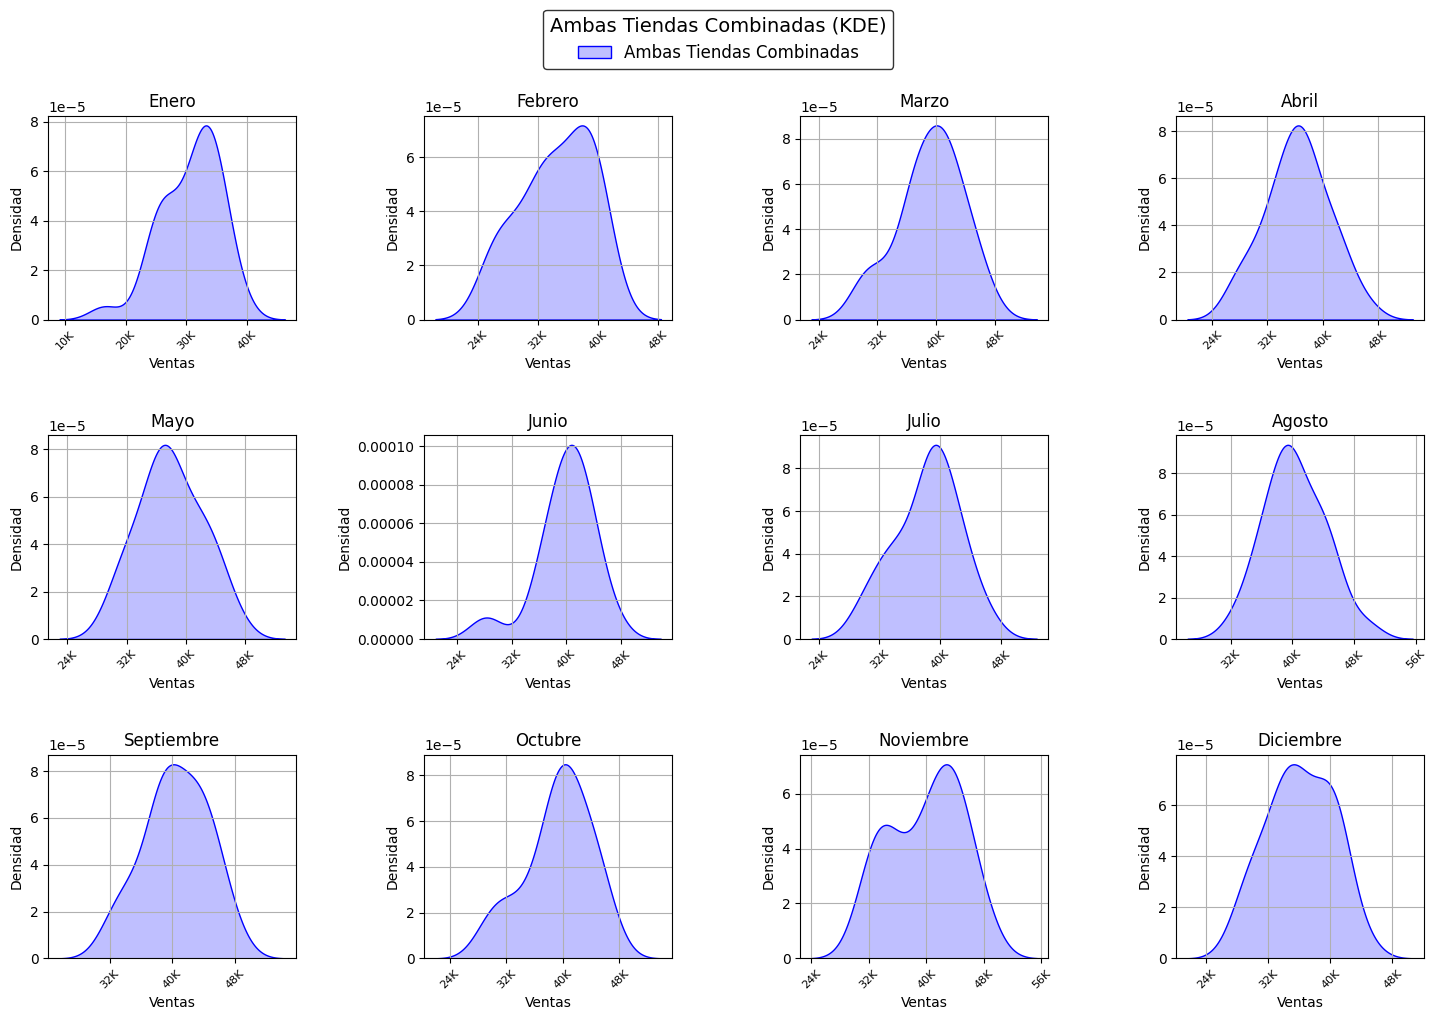

In [13]:
# KDE de las ventas combinadas por mes.
plot_por_mes(dfCombinado, plot_type='kde', filename_prefix='Combinado')
#plot_por_mes(dfCombinado['Santa Ana'], dfCombinado['La Floresta'], plot_type='kde')

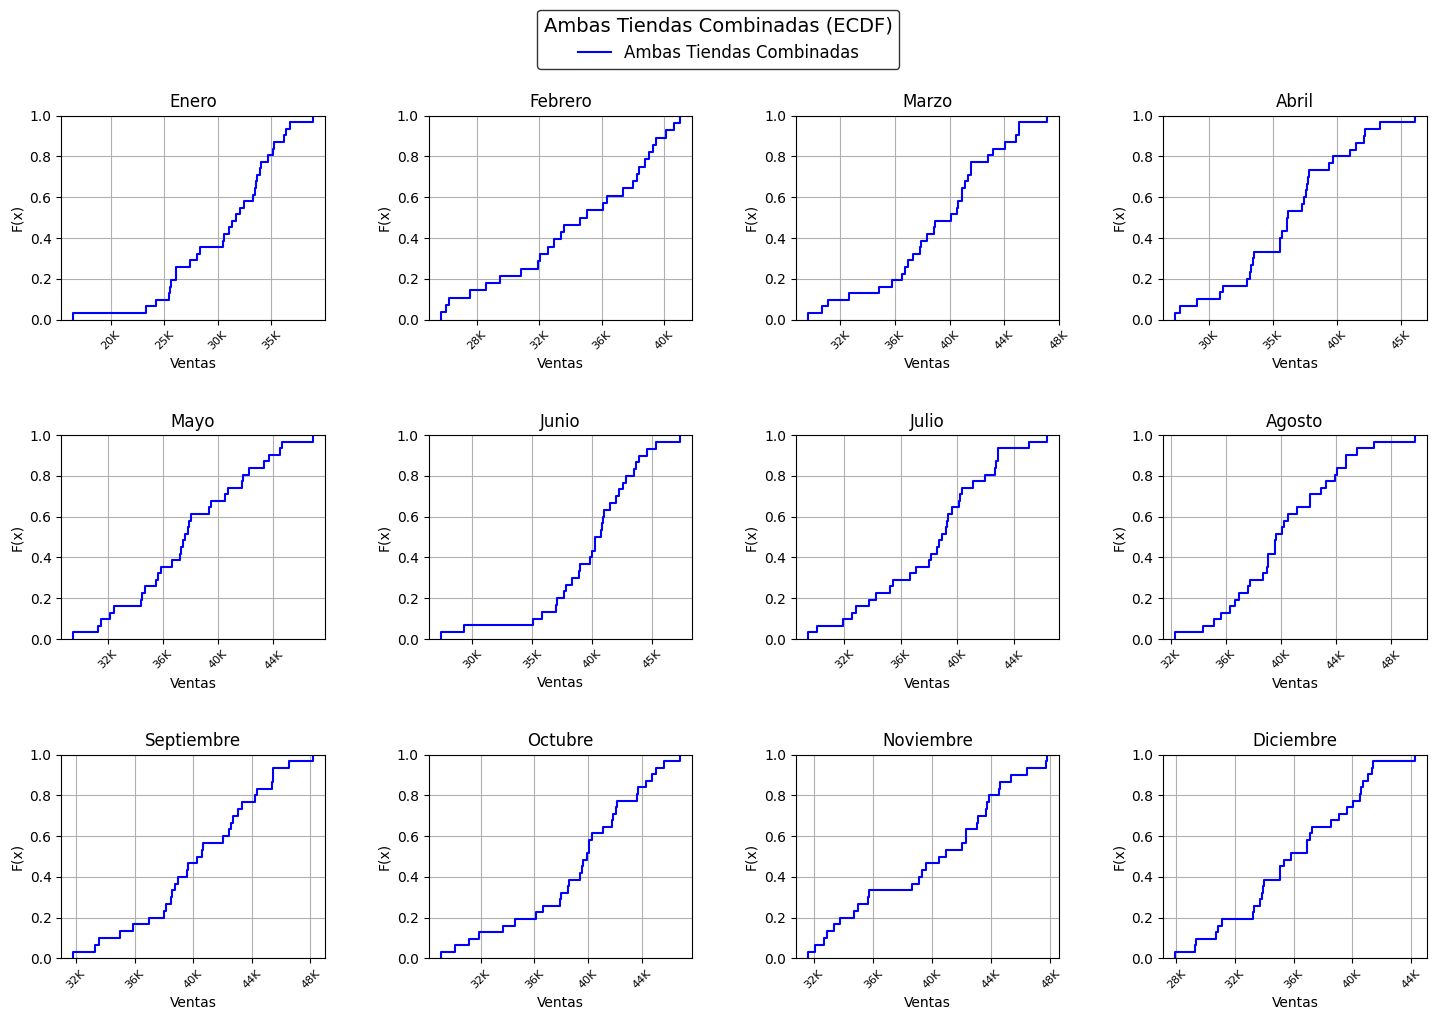

In [14]:
plot_por_mes(dfCombinado, plot_type='ecdf', filename_prefix='Combinado')

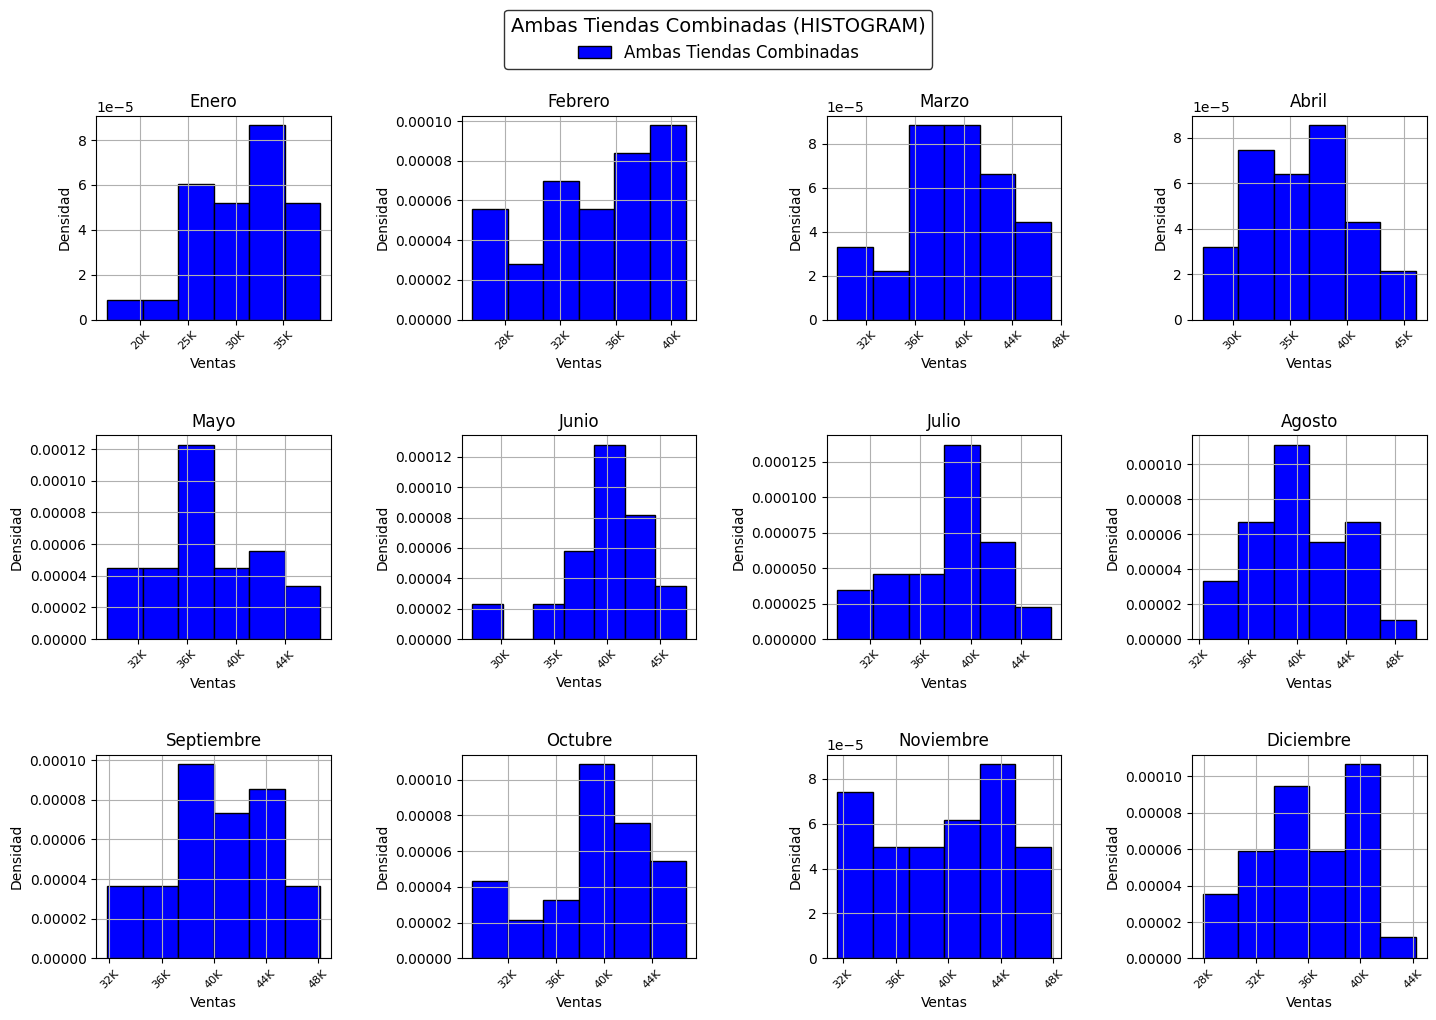

In [15]:
plot_por_mes(dfCombinado, plot_type='histogram', filename_prefix='Combinado')

In [16]:
combinado_95, combinado_99 = get_tsudent_por_mes(dfCombinado)

In [17]:
imprimir_intervalos_confianza(combinado_95, combinado_99, 'mes', 'Ambas Tiendas Combinadas')

,Tienda,mes,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,Ambas Tiendas Combinadas,1,30695.366959,28890.829735,32499.904183,28265.490619,33125.243300
1,Ambas Tiendas Combinadas,2,34389.782646,32539.564659,36240.000634,31891.346541,36888.218752
2,Ambas Tiendas Combinadas,3,39189.544569,37583.041996,40796.047143,37026.329235,41352.759904
3,Ambas Tiendas Combinadas,4,36292.346226,34587.861950,37996.830502,33995.187836,38589.504615
4,Ambas Tiendas Combinadas,5,37944.831289,36346.882586,39542.779993,35793.134058,40096.528520
5,Ambas Tiendas Combinadas,6,39911.523971,38318.494055,41504.553887,37764.574253,42058.473689
6,Ambas Tiendas Combinadas,7,38239.299565,36685.654082,39792.945047,36147.258265,40331.340864
7,Ambas Tiendas Combinadas,8,40295.125491,38861.155771,41729.095211,38364.232047,42226.018935
8,Ambas Tiendas Combinadas,9,40459.804632,38921.017492,41998.591771,38385.958696,42533.650567
9,Ambas Tiendas Combinadas,10,39279.956200,37576.303479,40983.608920,36985.924587,41573.987812


In [18]:
print(f"Media combinada de ventas de ambas tiendas: {dfCombinado['Ventas'].mean()}")


Media combinada de ventas de ambas tiendas: 37730.25875689808


# Resolución de las preguntas finales del TP.

## 1) (3.5 puntos) Determinen funciones empíricas de distribución para las ventas en ambas tiendas durante cada uno de los meses del año. Determinen tabién aproximaciones a las funciones de densidad para las distribuciones anteriores.
## Determine intervalos de confianza empíricos para cada mes, para significancias del 95 % y el 99 %.

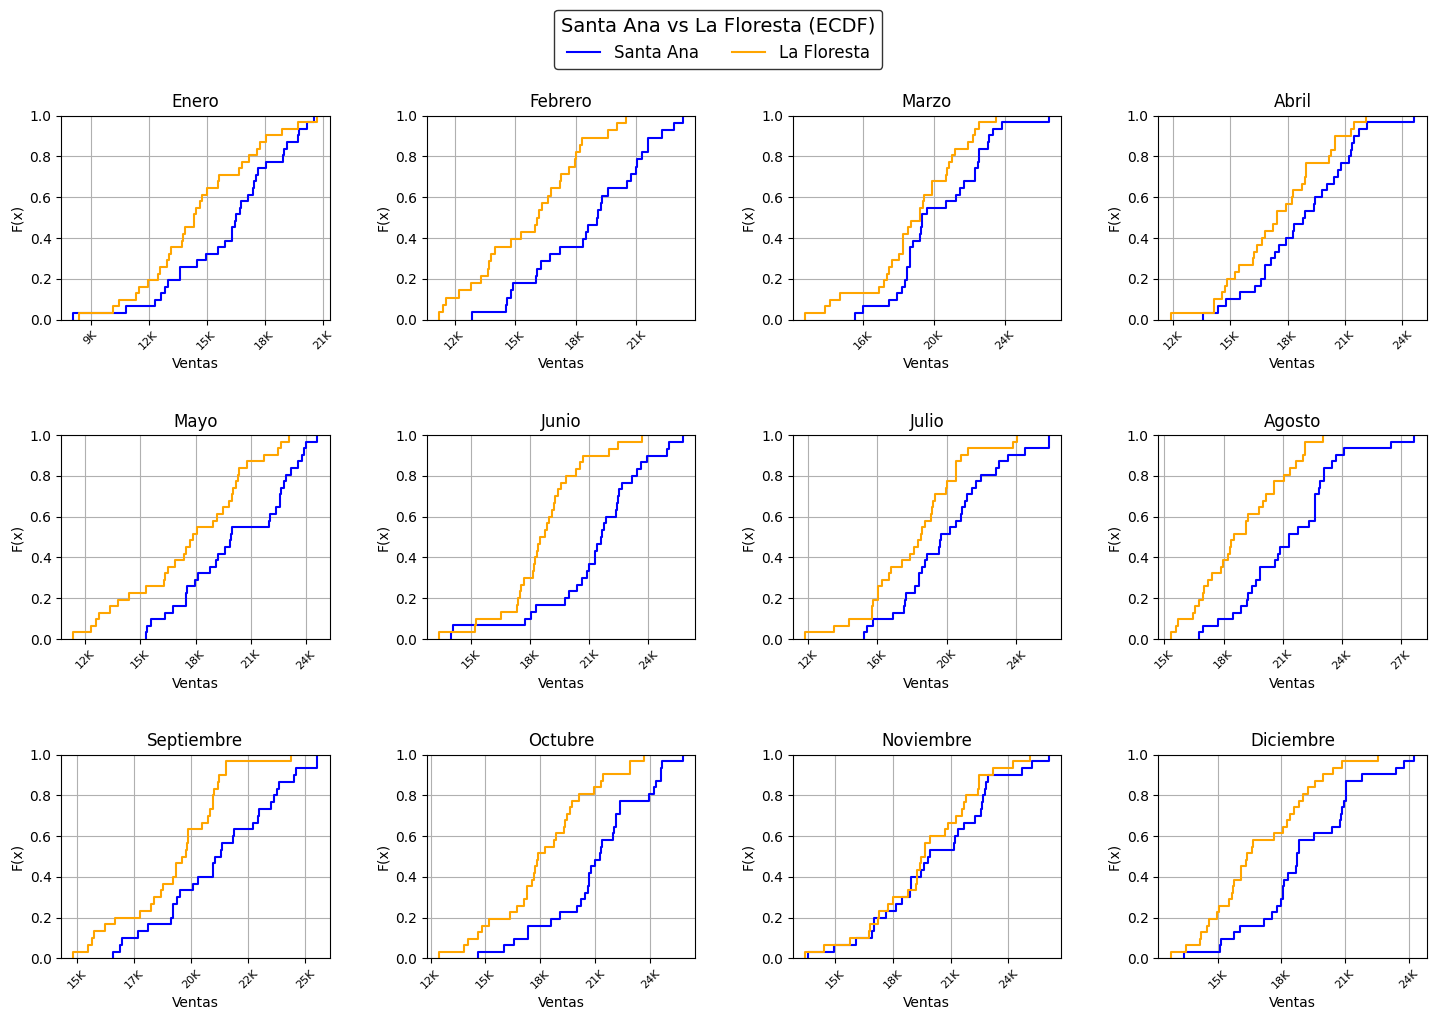

In [19]:
plot_por_mes(dfSantaAna_mensual, dfLaFloresta_mensual, plot_type='ecdf', filename_prefix='SantaAna_vs_LaFloresta_Mensual')

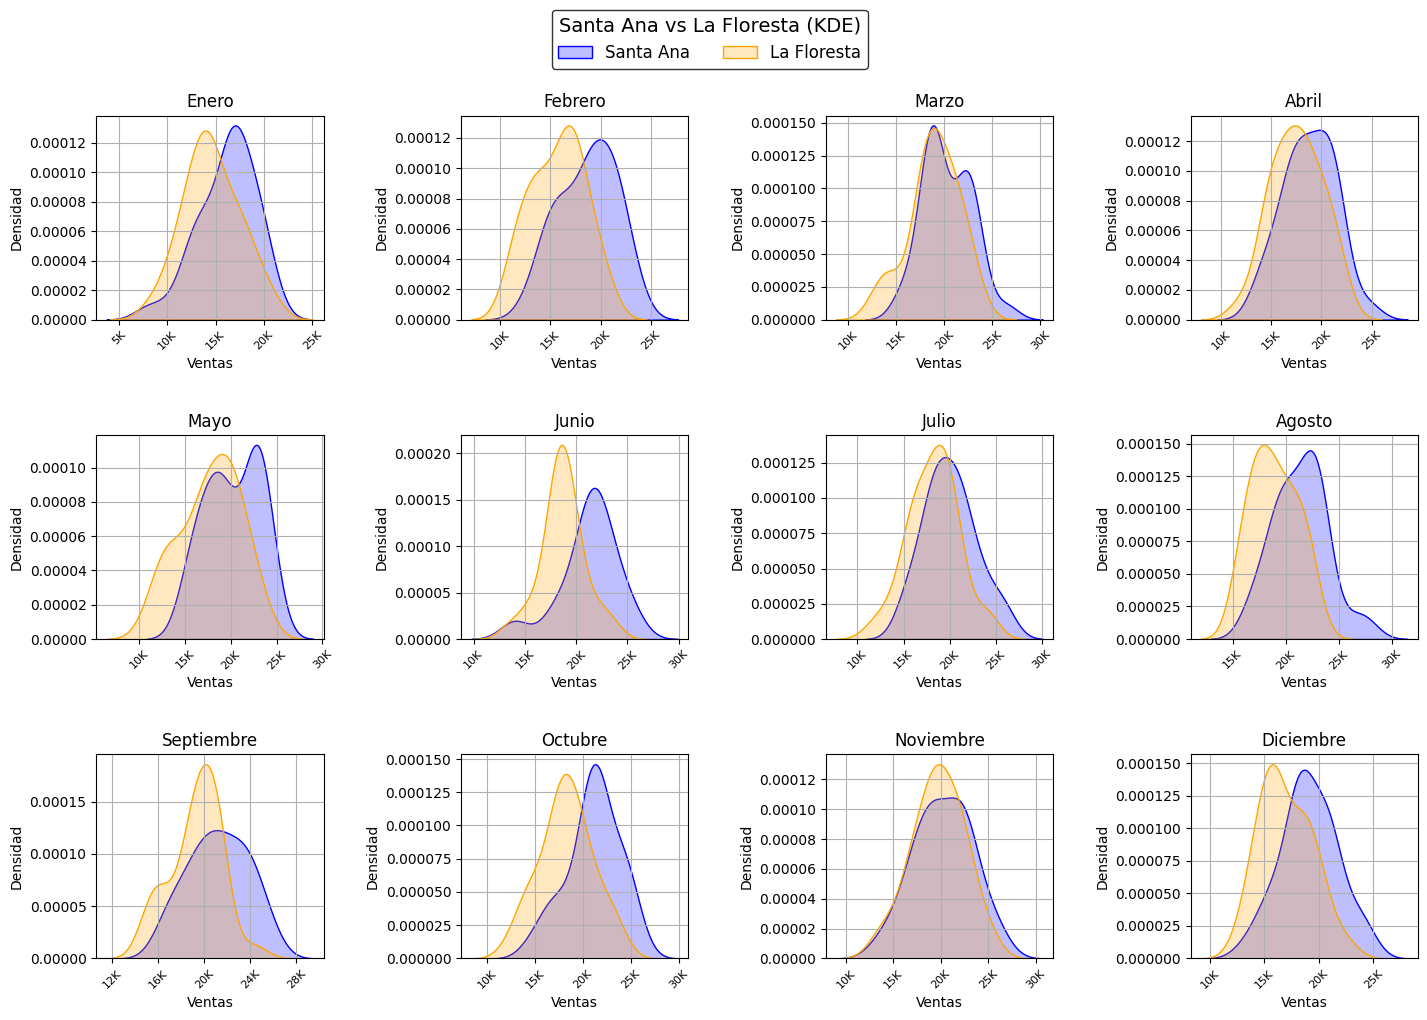

In [20]:
plot_por_mes(dfSantaAna_mensual, dfLaFloresta_mensual, plot_type='kde', filename_prefix='SantaAna_vs_LaFloresta_Mensual')


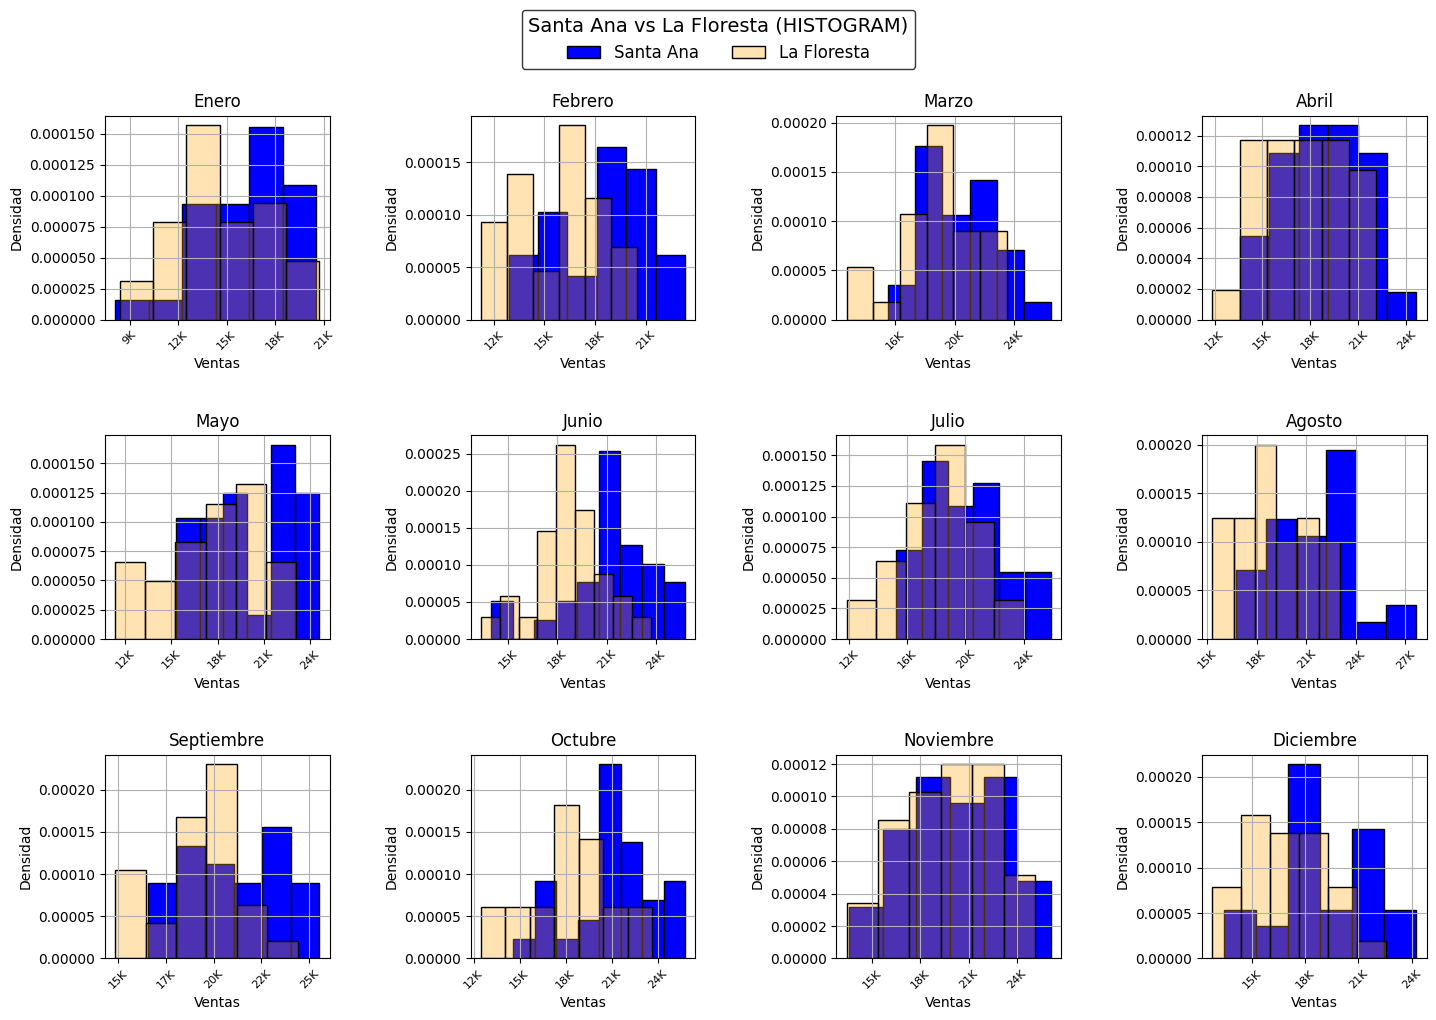

In [21]:
plot_por_mes(dfSantaAna_mensual, dfLaFloresta_mensual, plot_type='histogram', filename_prefix='SantaAna_vs_LaFloresta_Mensual')


In [22]:
SantaAna_95, SantaAna_99 = get_tsudent_por_mes(dfSantaAna)
LaFloresta_95, LaFloresta_99 = get_tsudent_por_mes(dfLaFloresta)

In [23]:
imprimir_intervalos_confianza(SantaAna_95, SantaAna_99, 'mes', 'Santa Ana')

,Tienda,mes,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,Santa Ana,1,16122.899357,15049.024706,17196.774009,14676.887286,17568.911428
1,Santa Ana,2,18649.163506,17546.930740,19751.396273,17160.766917,20137.560095
2,Santa Ana,3,20288.813455,19372.550914,21205.075996,19055.031940,21522.594971
3,Santa Ana,4,18772.741568,17806.619944,19738.863191,17470.685325,20074.797811
4,Santa Ana,5,20228.809364,19160.565493,21297.053234,18790.379348,21667.239379
5,Santa Ana,6,21249.626002,20222.590186,22276.661818,19865.474810,22633.777193
6,Santa Ana,7,20041.211660,19014.696759,21067.726562,18658.971250,21423.452071
7,Santa Ana,8,21382.439982,20454.230580,22310.649384,20132.571575,22632.308389
8,Santa Ana,9,21194.077173,20225.892210,22162.262137,19889.240137,22498.914210
9,Santa Ana,10,21059.617872,20053.115017,22066.120727,19704.324426,22414.911319


In [24]:
imprimir_intervalos_confianza(LaFloresta_95, LaFloresta_99, 'mes', 'La Floresta')

,Tienda,mes,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,La Floresta,1,14572.467602,13509.252055,15635.683149,13140.808411,16004.126794
1,La Floresta,2,15740.619140,14713.880856,16767.357424,14354.166291,17127.071989
2,La Floresta,3,18900.731114,17933.651399,19867.810828,17598.522389,20202.939839
3,La Floresta,4,17519.604658,16574.268942,18464.940374,16245.561886,18793.647430
4,La Floresta,5,17716.021926,16516.323891,18915.719960,16100.584000,19331.459851
5,La Floresta,6,18661.897969,17873.938823,19449.857115,17599.953903,19723.842035
6,La Floresta,7,18198.087904,17198.353917,19197.821891,16851.908989,19544.266819
7,La Floresta,8,18912.685509,18116.110904,19709.260114,17840.068242,19985.302776
8,La Floresta,9,19265.727459,18444.671051,20086.783866,18159.177729,20372.277188
9,La Floresta,10,18220.338327,17211.799829,19228.876826,16862.303812,19578.372843


In [25]:
#Metodo alternativo para imprimir los intervalos de confianza en forma de tabla:
from tabulate import tabulate
def imprimir_intervalos_confianza_2(intervalo_95, intervalo_99, frecuencia, tienda):
    # Combine the two intervals into a single list
    intervalos = []
    for row_95, row_99 in zip(intervalo_95, intervalo_99):
        # aseguramos que los valores de tienda y mes coincidan
        assert row_95[0] == row_99[0] and row_95[1] == row_99[1], "Mismatch in tienda or mes"
        # creamos la fila combinada
        combined_row = [
            row_95[0],  # Tienda
            row_95[1],  # Mes
            row_95[2],  # Media
            row_95[3],  # Lower 95%
            row_95[4],  # Upper 95%
            row_99[3],  # Lower 99%
            row_99[4]   # Upper 99%
        ]
        intervalos.append(combined_row)
    headers = ["Tienda", frecuencia, "Media", "Límite Inferior (95%)", "Límite Superior (95%)", "Límite Inferior (99%)", "Límite Superior (99%)"]
    # Print table
    print(tabulate(intervalos, headers=headers, tablefmt="grid", floatfmt=".4f"))

## 2) (3.5 puntos) Determine funciones empíricas de distribución para las ventas en ambas tiendas por cada día de la semana. Establezcan aproximaciones a las funciones de densidad para las distribuciones anteriores. Establezcan también intervalos de confianza empíricos para cada día de la semana, para significancias del 95 % y el 99 %.

In [26]:
#Función para agrupar las ventas por día
def ventas_por_dia(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
    df['DayOfWeek'] = df['Fecha'].dt.day_name()
    return df

In [27]:
dfSantaAna_diario = ventas_por_dia(dfSantaAna)
dfLaFloresta_diario = ventas_por_dia(dfLaFloresta)
#Función para graficar las ventas por día de acuerdo a la función requerida

In [28]:
dfLaFloresta_diario

,Fecha,Ventas,Tienda,mes,Nombre_Mes,DayOfWeek
0,2023-01-01,14767.536664,La Floresta,1,January,Sunday
1,2023-01-02,13889.323232,La Floresta,1,January,Monday
2,2023-01-03,11491.085327,La Floresta,1,January,Tuesday
3,2023-01-04,18903.512075,La Floresta,1,January,Wednesday
4,2023-01-05,13703.219431,La Floresta,1,January,Thursday
...,...,...,...,...,...,...
360,2023-12-27,15757.734800,La Floresta,12,December,Wednesday
361,2023-12-28,16625.746643,La Floresta,12,December,Thursday
362,2023-12-29,19025.415563,La Floresta,12,December,Friday
363,2023-12-30,15517.542208,La Floresta,12,December,Saturday


In [29]:
#Funcion para graficar las ventas por mes de acuerdo a la funcion requerida
def plot_por_dia(df1, df2, plot_type='kde', filename_prefix=''):
    # Ver que tengan las columnas requeridas
    required_columns = ['DayOfWeek', 'Ventas']
    if not all(col in df1.columns for col in required_columns) or not all(col in df2.columns for col in required_columns):
        raise ValueError("Both DataFrames must have 'mes' and 'Ventas' columns")
    
    tienda1 = df1['Tienda'].unique()[0]
    tienda2 = df2['Tienda'].unique()[0] if df2 is not None else None
    dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    #dias = sorted(dias)
        # Map days to Spanish for output
    day_map = {
        'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
        'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
    }
    plt.figure(figsize=(15, 10))
    
    # reducimos la notación de los valores para no comprimir el gráfico (e.g., 1000 -> 1K)
    def thousands_formatter(x, pos):
        if x >= 1000:
            return f'{int(x/1000)}K'
        return f'{int(x)}'
    
    for i, dia in enumerate(dias, 1):
        ventas1_dia = df1[df1['DayOfWeek'] == dia]['Ventas'].dropna()
        ventas2_dia = df2[df2['DayOfWeek'] == dia]['Ventas'].dropna()
        
        if len(ventas1_dia) == 0 and len(ventas2_dia) == 0:
            continue  # Verificar que haya datos para el mes
        
        plt.subplot(3, 4, i)
        
        if plot_type == 'kde':
            sns.kdeplot(ventas1_dia, color='blue', fill=True, label=tienda1 if i == 1 else None)
            sns.kdeplot(ventas2_dia, color='orange', fill=True, label=tienda2 if i == 1 else None)
        elif plot_type == 'ecdf':
            # Calcular la ECDF
            sns.ecdfplot(data=ventas1_dia, color='blue', label=tienda1 if i == 1 else None)
            sns.ecdfplot(data=ventas2_dia, color='orange', label=tienda2 if i == 1 else None)   
        elif plot_type == 'histogram':
            sns.histplot(ventas1_dia, color='blue', alpha=1, label=tienda1 if i == 1 else None)
            sns.histplot(ventas2_dia, color='orange', alpha=0.3, label=tienda2 if i == 1 else None)
        else:
            raise ValueError("Invalid plot type. Choose 'kde', 'ecdf', or 'histogram'.")
        
        
        plt.title(f'{day_map[dia]}')
        plt.xlabel('Ventas')
        plt.ylabel('F(x)')
        plt.grid(True)
        
        # Convertir el eje X con la reducción de miles 
        plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
        # setear el número máximo de ticks en el eje X
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        # setear el número máximo de ticks en el eje Y
        plt.xticks(rotation=45, fontsize=8)
    
    plt.tight_layout(pad=3.0)
    # Agregar título general del gráfico
    plt.figlegend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fontsize=12,
        title=f"{tienda1} vs {tienda2} ",
        title_fontsize=14,
        frameon=True,
        edgecolor='black'
    )
    plt.savefig(f'graphs/{filename_prefix}_{plot_type}_comparison.png', bbox_inches='tight')
    plt.show()
    plt.close()


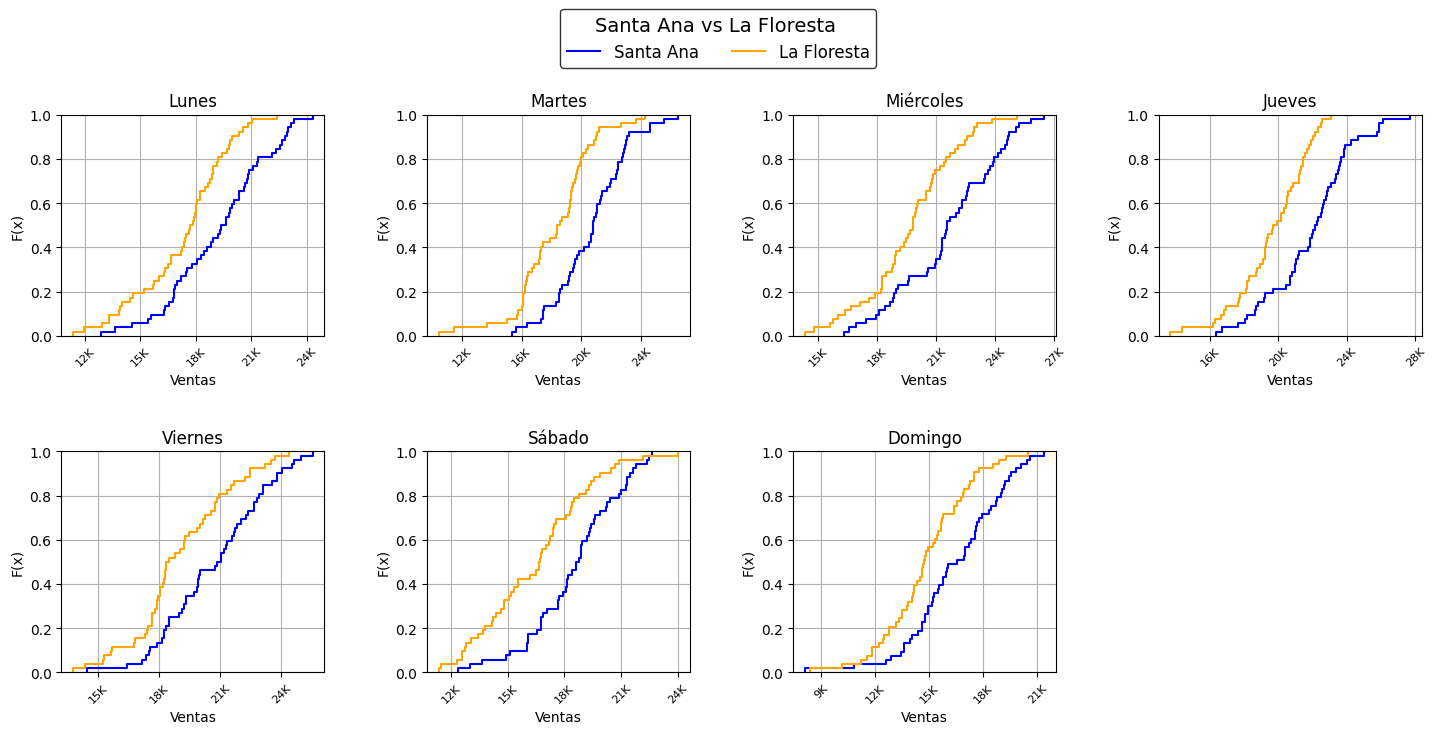

In [30]:
plot_por_dia(dfSantaAna_diario, dfLaFloresta_diario, 'ecdf', filename_prefix='SantaAna_vs_LaFloresta_Diario')

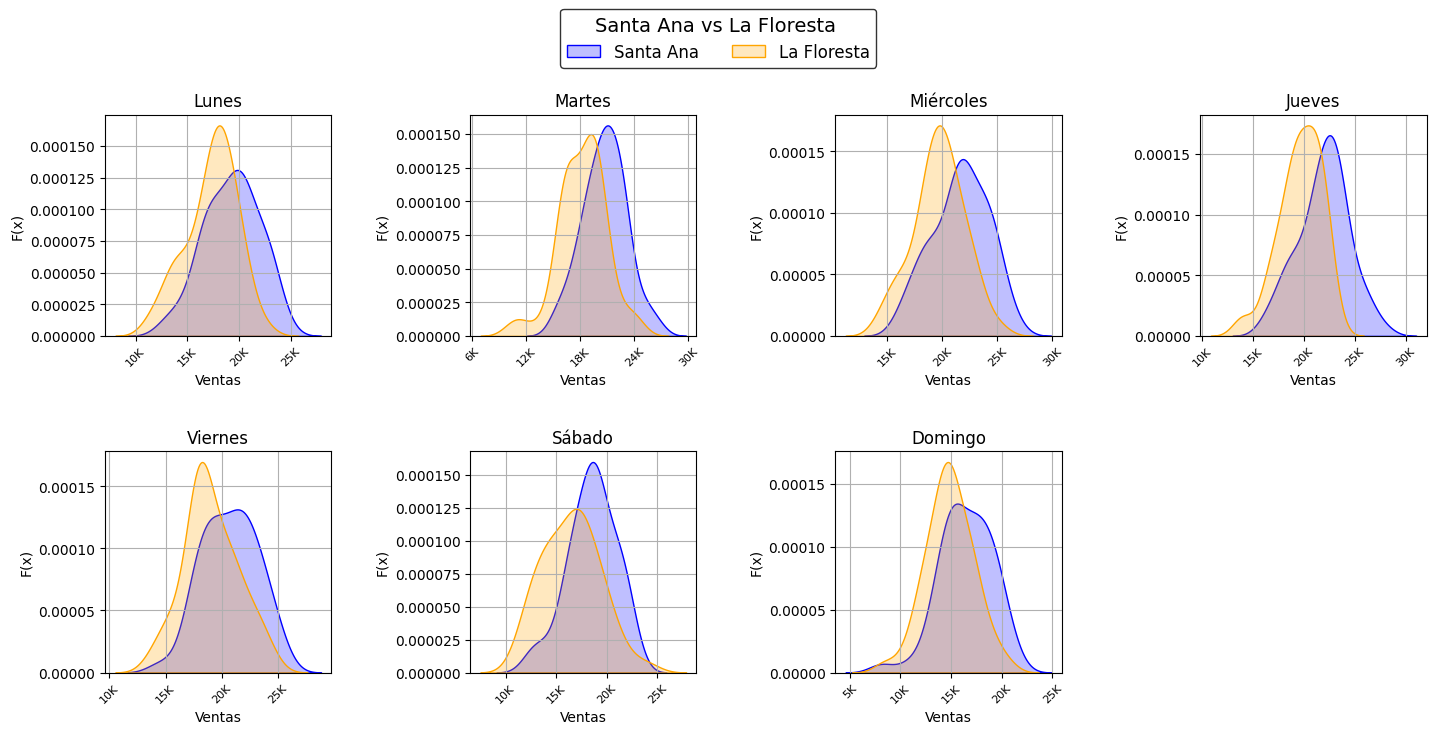

In [31]:
plot_por_dia(dfSantaAna_diario, dfLaFloresta_diario, 'kde', filename_prefix='SantaAna_vs_LaFloresta_Diario')

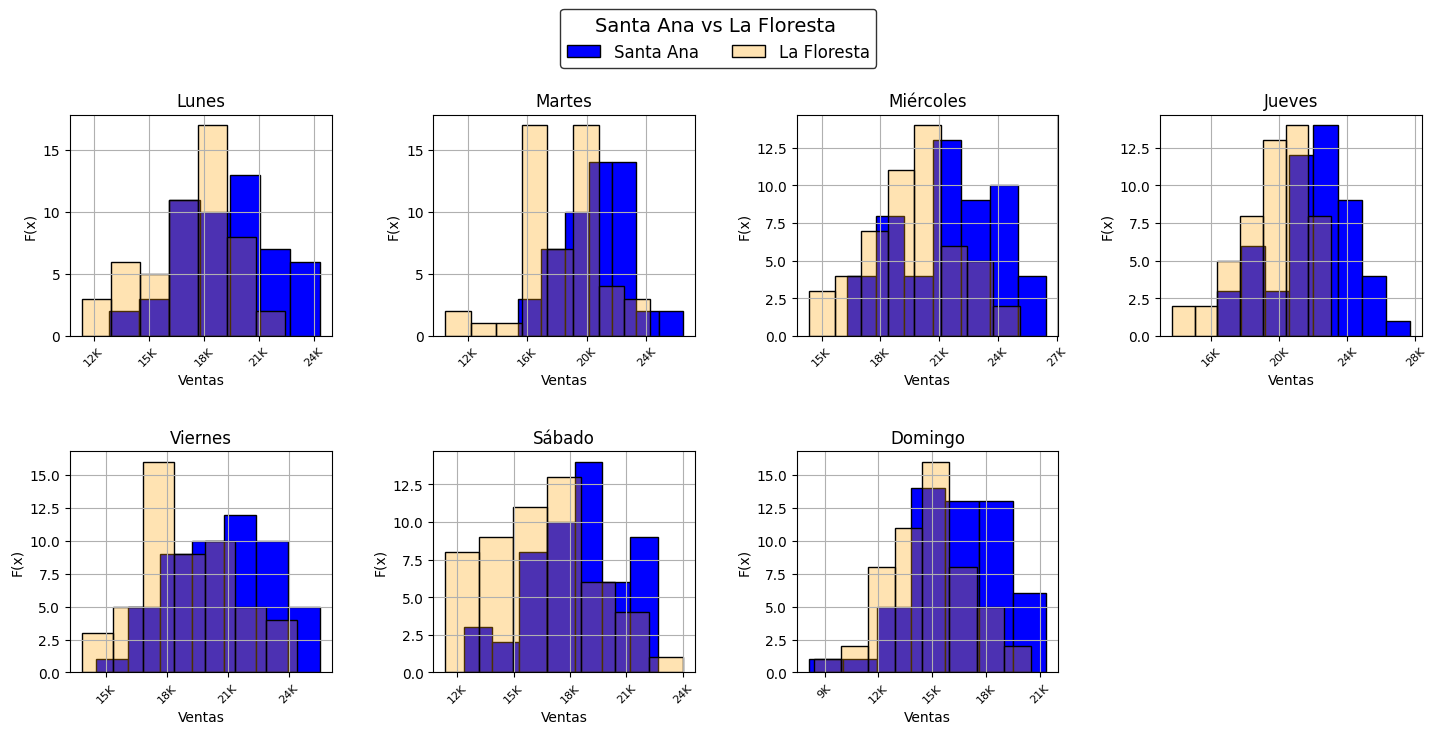

In [32]:
plot_por_dia(dfSantaAna_diario, dfLaFloresta_diario, 'histogram', filename_prefix='SantaAna_vs_LaFloresta_Diario')

In [33]:
def get_tsudent_por_dia(df, tienda):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dias = pd.DataFrame(days, columns=['DayOfWeek'])
    dias = dias['DayOfWeek'].unique()   
    #dias = sorted(dias)
    
    dist_95 = []
    dist_99 = []
    
    for dia in dias:
        ventas_dia = df[df['DayOfWeek'] == dia]['Ventas'].dropna()
        n = len(ventas_dia)
        media = float(np.mean(ventas_dia))  # Convert to Python float
        desv = float(np.std(ventas_dia, ddof=1))  # Convert to Python float
        
        # Intervalo de confianza al 95%
        alpha_95 = 0.05
        t_crit_95 = t.ppf(1 - alpha_95/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        lower_95 = float(media - margen_error_95)  # Convert to Python float
        upper_95 = float(media + margen_error_95)  # Convert to Python float
        dist_95.append([tienda, dia, media, lower_95, upper_95])  # Convert mes to int
        
        # Intervalo de confianza al 99%
        alpha_99 = 0.01
        t_crit_99 = t.ppf(1 - alpha_99/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        lower_99 = float(media - margen_error_99)  # Convert to Python float
        upper_99 = float(media + margen_error_99)  # Convert to Python float
        dist_99.append([tienda, dia, media, lower_99, upper_99])  # Convert mes to int
    
    return dist_95, dist_99

In [34]:
SantaAna_95_diario, SantaAna_99_diario = get_tsudent_por_dia(dfSantaAna_diario, 'Santa Ana')
LaFloresta_95_diario, LaFloresta_99_diario = get_tsudent_por_dia(dfLaFloresta_diario, 'La Floresta')


In [35]:
imprimir_intervalos_confianza(SantaAna_95_diario, SantaAna_99_diario, 'Dia', 'Santa Ana')

,Tienda,Dia,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,Santa Ana,Monday,19244.702732,18505.978692,19983.426772,18260.125965,20229.279499
1,Santa Ana,Tuesday,20658.844140,19991.493221,21326.195059,19769.393987,21548.294293
2,Santa Ana,Wednesday,21598.446070,20895.511247,22301.380893,20661.569431,22535.322709
3,Santa Ana,Thursday,21924.710284,21240.111184,22609.309384,21012.271630,22837.148939
4,Santa Ana,Friday,20701.731556,20018.623189,21384.839923,19791.279762,21612.183350
5,Santa Ana,Saturday,18511.495461,17847.491121,19175.499801,17626.505653,19396.485270
6,Santa Ana,Sunday,16451.761843,15734.595723,17168.927963,15496.182032,17407.341654


In [36]:
imprimir_intervalos_confianza(LaFloresta_95_diario, LaFloresta_99_diario, 'Dia', 'La Floresta')

,Tienda,Dia,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,La Floresta,Monday,17305.413578,16623.687985,17987.139172,16396.804754,18214.022403
1,La Floresta,Tuesday,18196.320038,17469.477532,18923.162543,17227.579066,19165.061010
2,La Floresta,Wednesday,19661.000324,19017.269565,20304.731083,18803.031291,20518.969357
3,La Floresta,Thursday,19635.252932,19054.054174,20216.451690,18860.627005,20409.878859
4,La Floresta,Friday,19041.863697,18373.708579,19710.018815,18151.341701,19932.385692
5,La Floresta,Saturday,16475.815250,15687.780355,17263.850144,15425.516618,17526.113882
6,La Floresta,Sunday,14828.491951,14183.745400,15473.238502,13969.406768,15687.577134


## 3. (3 puntos) Realicen pruebas de hipótesis, con base en los datos, para aceptar o rechazar la intuición de Don Francisco, con significancias de 95% y 99 %.

### ANOVA
Comenzamos realizando un análisis de ANOVA para determinar si las medias son distintas. Para esto tomamos un $\alpha$ de 0,05 (significancia de 95%).
Las hipótesis son:
* $H_0$: Las medias de ventas de Santa Ana y La Floresta son iguales.
* $H_1$: Al menos una es diferente.

In [37]:
from scipy.stats import f_oneway

# f_oneway recibe los datos de los dos grupos
f_stat, p_anova = f_oneway(dfSantaAna['Ventas'], dfLaFloresta['Ventas'])
print("Estadístico F:", f_stat)
print("p-value:", p_anova)

Estadístico F: 80.29307074566687
p-value: 2.6772734947770504e-18


Como el valor de $\alpha$ es menor a 0,05, rechazamos la hipótesis nula con nivel de significancia de 95%, y las ventas son distintas.<br>
Como el valor de $\alpha$ es menor a 0,01, rechazamos la hipótesis nula con nivel de significancia de 99%, y las ventas son distintas.<br>

### Test de hipótesis para diferencia de medias
Para comprobar si efectivamente las ventas de Santa Ana son mayores que las de La Floresta, realizamos el siguiente test de hipótesis:
* $H_0$: La media de La Floresta = Santa Ana
* $H_1$: La media de La Floresta < Santa Ana
<br>
Dado que las varianzas de las poblaciones son desconocidas, utilizamos t de Student.

In [41]:
from scipy.stats import ttest_ind

# Medias de los dos grupos
media_la_floresta = dfLaFloresta['Ventas'].mean()
media_santa_ana = dfSantaAna['Ventas'].mean()

# Imprimir medias
print("Media La Floresta:", media_la_floresta)
print("Media Santa Ana:", media_santa_ana)

# Niveles de significancia:
alpha_95 = 0.05  # 95% 
alpha_99 = 0.01  # 99% 

# Realizar la prueba t para ver si Santa Ana tiene media mayor
t_stat, p_two_tailed = ttest_ind(dfLaFloresta['Ventas'], dfSantaAna['Ventas'], equal_var=True)
p_value_one_sided = p_value_two_sided / 2 if t_stat < 0 else 1 - (p_value_two_sided / 2)


# Imprimir resultados
print("Prueba de Hipótesis: ¿Vende menos La Floresta que Santa Ana?")
print(f"H0: μ_La Floresta = μ_Santa Ana")
print(f"H1: μ_La Floresta < μ_Santa Ana")
print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p (una cola): {p_value_one_sided}")


# Interpretación de la prueba
# Significancia del 95% 
print("\nNivel de significancia 95% (α = 0.05):")
if p_value_one_sided < alpha_95 and t_stat < 0:
    print("Con nivel de significa 95%, rechazamos la hipótesis nula")
else:
    print("Con nivel de significa 95%, no rechazamos la hipótesis nula")

# Significancia del 99% 
print("\nNivel de significancia 99% (α = 0.01):")
if p_value_one_sided < alpha_99 and t_stat < 0:
    print("Con nivel de significa 99%, rechazamos la hipótesis nula")
else:
    print("Con nivel de significa 99%, no rechazamos la hipótesis nula")



Media La Floresta: 17869.38272866446
Media Santa Ana: 19860.876028233622
Prueba de Hipótesis: ¿Vende menos La Floresta que Santa Ana?
H0: μ_La Floresta = μ_Santa Ana
H1: μ_La Floresta < μ_Santa Ana
Estadístico t: -8.9606
Valor p (una cola): 1.3429389390314894e-18

Nivel de significancia 95% (α = 0.05):
Con nivel de significa 95%, rechazamos la hipótesis nula

Nivel de significancia 99% (α = 0.01):
Con nivel de significa 99%, rechazamos la hipótesis nula


* Como $\alpha$ < 0,05, con nivel de significancia de 95% se rechaza la hipótesis nula, y Santa Ana efectivamente tiene un promedio de ventas mayor que la Floresta
* Como $\alpha$ < 0,01, con nivel de significancia de 99% se rechaza la hipótesis nula, y Santa Ana efectivamente tiene un promedio de ventas mayor que la Floresta